In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score
from sklearn.decomposition import PCA
from keras.datasets import mnist
from sklearn.datasets import make_classification

2024-01-09 17:42:24.116001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 17:42:24.161237: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
n_samples = 1000  # 数据集中的样本数
n_features = 20   # 每个样本的特征数
n_classes = 3     # 分类的类别数
n_clusters_per_class = 1 # 每个类别的簇数

# 生成数据集
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_classes=n_classes, 
                           n_clusters_per_class=n_clusters_per_class, random_state=42)

# # 展示一些生成的数据
X[:5], y[:5]

(array([[-0.53279321,  2.30368954, -0.99714355, -0.40635685,  0.20518489,
         -1.60357548, -0.06480925,  0.4473863 ,  0.60193624,  1.26176116,
         -1.20153539, -1.33672208, -0.35969267, -0.16584091, -1.92830992,
          1.5206009 ,  0.85000427, -1.23735369,  2.04610733, -0.29666874],
        [-0.9600463 ,  2.50600626,  1.987276  ,  0.19981043,  0.10575379,
         -1.34656318,  0.91136272,  0.54347938,  0.09337237,  0.28872366,
          1.26370668, -0.84631598,  1.2723535 ,  0.26402008, -2.2883471 ,
          0.7324921 , -0.12270893, -1.65488744,  2.32005253, -1.36831504],
        [-0.32351495, -0.91296766,  1.02196316,  0.44807834,  1.37814268,
          1.09318749,  0.73317932,  0.7589817 ,  0.9109444 ,  0.5400178 ,
         -0.99062322, -0.34319157,  0.42053671,  1.53238038,  0.54483483,
          1.8481091 ,  0.01428721,  1.06216745, -0.7024605 , -0.34109293],
        [-0.90092112, -0.53960907,  0.50112928,  0.70138989, -0.0102056 ,
          2.37941514, -0.48663119, 

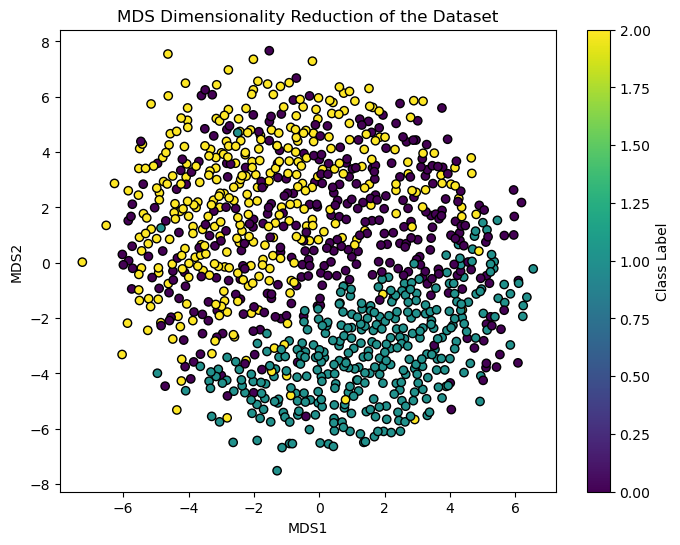

In [12]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# 应用 MDS 降维
mds = MDS(n_components=2, random_state=0)
X_mds = mds.fit_transform(X)

# 绘制 MDS 结果
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("MDS Dimensionality Reduction of the Dataset")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.colorbar(label='Class Label')
plt.show()



In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 将图像数据转换为一维数组
x_train_reshaped = x_train.reshape((x_train.shape[0], -1))
x_test_reshaped = x_test.reshape((x_test.shape[0], -1))

# 使用PCA进行数据降维以加快聚类过程
pca = PCA(n_components=50)  # 选择50个主成分
x_train_pca = pca.fit_transform(x_train_reshaped)
x_test_pca = pca.transform(x_test_reshaped)

# 使用前1000个样本进行聚类，以加快速度
x_sample = x_train_pca[:1000]

# 定义聚类算法
kmeans = KMeans(n_clusters=10, random_state=0)
dbscan = DBSCAN(eps=3, min_samples=5)
gmm = GaussianMixture(n_components=10, random_state=0)

In [8]:
labels_kmeans = kmeans.fit_predict(X)
labels_dbscan = dbscan.fit_predict(X)
labels_gmm = gmm.fit_predict(X)


In [9]:
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_dbscan = silhouette_score(X, labels_dbscan)
silhouette_gmm = silhouette_score(X, labels_gmm)


In [10]:

davies_bouldin_kmeans = davies_bouldin_score(x_sample, labels_kmeans)
davies_bouldin_dbscan = davies_bouldin_score(x_sample, labels_dbscan)
davies_bouldin_gmm = davies_bouldin_score(x_sample, labels_gmm)

calinski_harabasz_kmeans = calinski_harabasz_score(x_sample, labels_kmeans)
calinski_harabasz_dbscan = calinski_harabasz_score(x_sample, labels_dbscan)
calinski_harabasz_gmm = calinski_harabasz_score(x_sample, labels_gmm)

# 由于Mutual Information需要真实标签，我们使用测试集的一部分
labels_true = y_test[:1000]
mutual_info_kmeans = mutual_info_score(labels_true, labels_kmeans)
mutual_info_dbscan = mutual_info_score(labels_true, labels_dbscan)
mutual_info_gmm = mutual_info_score(labels_true, labels_gmm)

In [11]:
{
    "Silhouette Coefficient": {
        "KMeans": silhouette_kmeans,
        "DBSCAN": silhouette_dbscan,
        "GMM": silhouette_gmm
    },
    "Davies-Bouldin Index": {
        "KMeans": davies_bouldin_kmeans,
        "DBSCAN": davies_bouldin_dbscan,
        "GMM": davies_bouldin_gmm
    },
    "Calinski-Harabasz Index": {
        "KMeans": calinski_harabasz_kmeans,
        "DBSCAN": calinski_harabasz_dbscan,
        "GMM": calinski_harabasz_gmm
    },
    "Mutual Information": {
        "KMeans": mutual_info_kmeans,
        "DBSCAN": mutual_info_dbscan,
        "GMM": mutual_info_gmm
    }
}

{'Silhouette Coefficient': {'KMeans': 0.04605632806277489,
  'DBSCAN': -0.22245125031550148,
  'GMM': 0.019219244950577433},
 'Davies-Bouldin Index': {'KMeans': 17.09916702679876,
  'DBSCAN': 5.450353849843219,
  'GMM': 17.658645273936735},
 'Calinski-Harabasz Index': {'KMeans': 0.986374150570366,
  'DBSCAN': 1.0281609950102855,
  'GMM': 1.005299228116662},
 'Mutual Information': {'KMeans': 0.03265800913730643,
  'DBSCAN': 0.0227184753565059,
  'GMM': 0.043046251360552935}}